### Importing libraries

In [48]:
import warnings
warnings.filterwarnings('ignore')

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

import itertools

### Read and understand the data

In [50]:
bike = pd.read_csv('day.csv')
bike.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [51]:
bike.shape

(730, 16)

In [52]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


- There is no missing values.  
- We dont need data cleaning

### Data Preprocessing

In [53]:
# Dropping 'dteday' column because we alredy have year, month, day(weekday, workingday) columns
bike1 = bike.drop(['dteday'], axis=1)
bike1.head()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


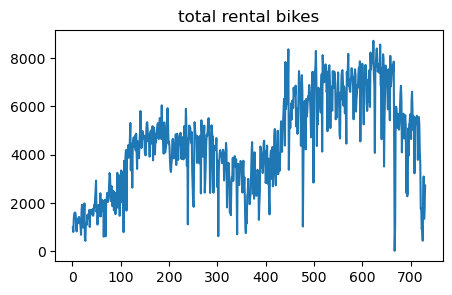

In [54]:
plt.figure(figsize=(5,3))
plt.plot(bike1['instant'], bike1['cnt'])
plt.title('total rental bikes')
plt.show()

### Adding dummy variables

#### weathersit :   
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy  
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist  
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds  
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog  

In [55]:
def get_weather(x):
    if x == 1:
        return 'clear_weather'
    elif x == 2:
        return 'mist_weather'
    elif x == 3:
        return 'light_weather'
    elif x == 4:
        return 'heavy_weather'
    
bike1['weathersit'] = bike1['weathersit'].apply(get_weather)

# There is no heavy weather so we are taking only 2 dummy variables
bike1['weathersit'].value_counts()

clear_weather    463
mist_weather     246
light_weather     21
Name: weathersit, dtype: int64

In [56]:
weather_dummy = pd.get_dummies(bike1['weathersit'])
weather_dummy = weather_dummy.drop('clear_weather', axis=1)

# Concatinating weather_dummy with bike df
bike2 = pd.concat([bike1, weather_dummy], axis=1)

# Dropping weathersit
bike2 = bike2.drop('weathersit', axis=1)
bike2.head()

,instant,season,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,light_weather,mist_weather
0,1,1,0,1,0,6,0,14.110847,18.18125,80.5833,10.749882,331,654,985,0,1
1,2,1,0,1,0,0,0,14.902598,17.68695,69.6087,16.652113,131,670,801,0,1
2,3,1,0,1,0,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349,0,0
3,4,1,0,1,0,2,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562,0,0
4,5,1,0,1,0,3,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600,0,0


##### Status: light_weather, mist_weather  
00 = clear weather   
10 = light weather   
01 = mist weather   


#### Season
(1:spring, 2:summer, 3:fall, 4:winter)

In [57]:
# We need 3 dummy variables
bike2['season'].value_counts()

3    188
2    184
1    180
4    178
Name: season, dtype: int64

In [58]:
def get_season(x):
    if x == 1:
        return 'spring'
    elif x == 2:
        return 'summer'
    elif x == 3:
        return 'fall'
    else:
        return 'winter'
    

bike2['season'] = bike2['season'].apply(get_season)
season_dummy = pd.get_dummies(bike2['season'], drop_first=True)

# Cocatinating season_dummy with bike df
bike3 = pd.concat([bike2, season_dummy], axis=1)

# Drop Season column
bike3 = bike3.drop('season', axis=1)
bike3.head()

,instant,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,light_weather,mist_weather,spring,summer,winter
0,1,0,1,0,6,0,14.110847,18.18125,80.5833,10.749882,331,654,985,0,1,1,0,0
1,2,0,1,0,0,0,14.902598,17.68695,69.6087,16.652113,131,670,801,0,1,1,0,0
2,3,0,1,0,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349,0,0,1,0,0
3,4,0,1,0,2,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562,0,0,1,0,0
4,5,0,1,0,3,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600,0,0,1,0,0


##### Status: spring, summer, winter  
000 = fall   
100 = spring   
010 = summer   
001 = winter

### Correlation between features

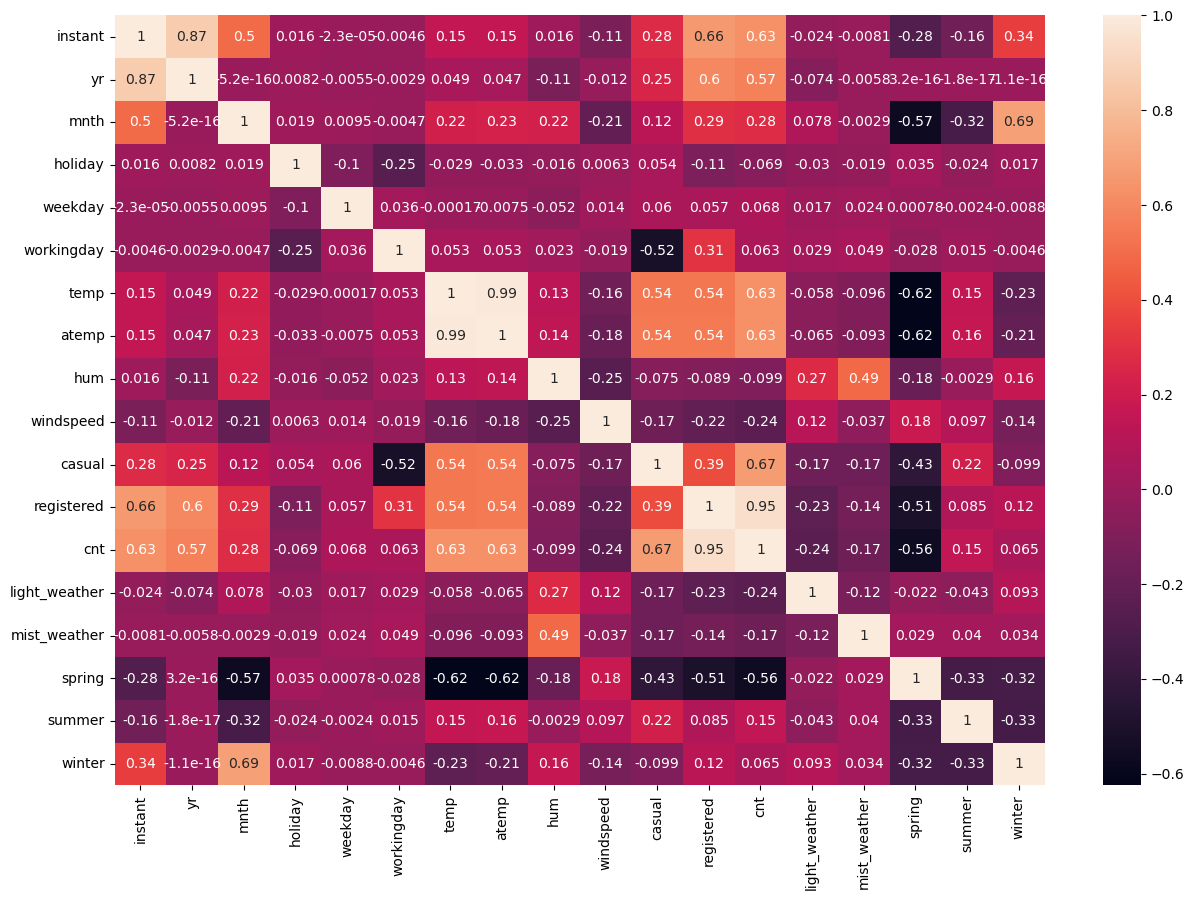

In [59]:
plt.figure(figsize=(15, 10))
sns.heatmap(bike3.corr(), annot=True)
plt.show()

Very High correlation
1. Month and season (0.83)
2. temp and atemp (0.99)
3. registerd and o/p cnt (0.95)
4. casual and o/p cnt (0.67)
5. temp and o/p cnt (0.63)
6. year and o/p cnt (0.57)
7. High negative correlation - casual with workingday(-0.52)
8. High negative correlation - spring with temp and atemp(-0.62)
9. High negative correlation - spring with casual and registerd(-0.43, -0.51) thus with cnt(-0.56)

## Pair-plot

In [60]:
bike3.columns

Index(['instant', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'temp',
       'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt',
       'light_weather', 'mist_weather', 'spring', 'summer', 'winter'],
      dtype='object')

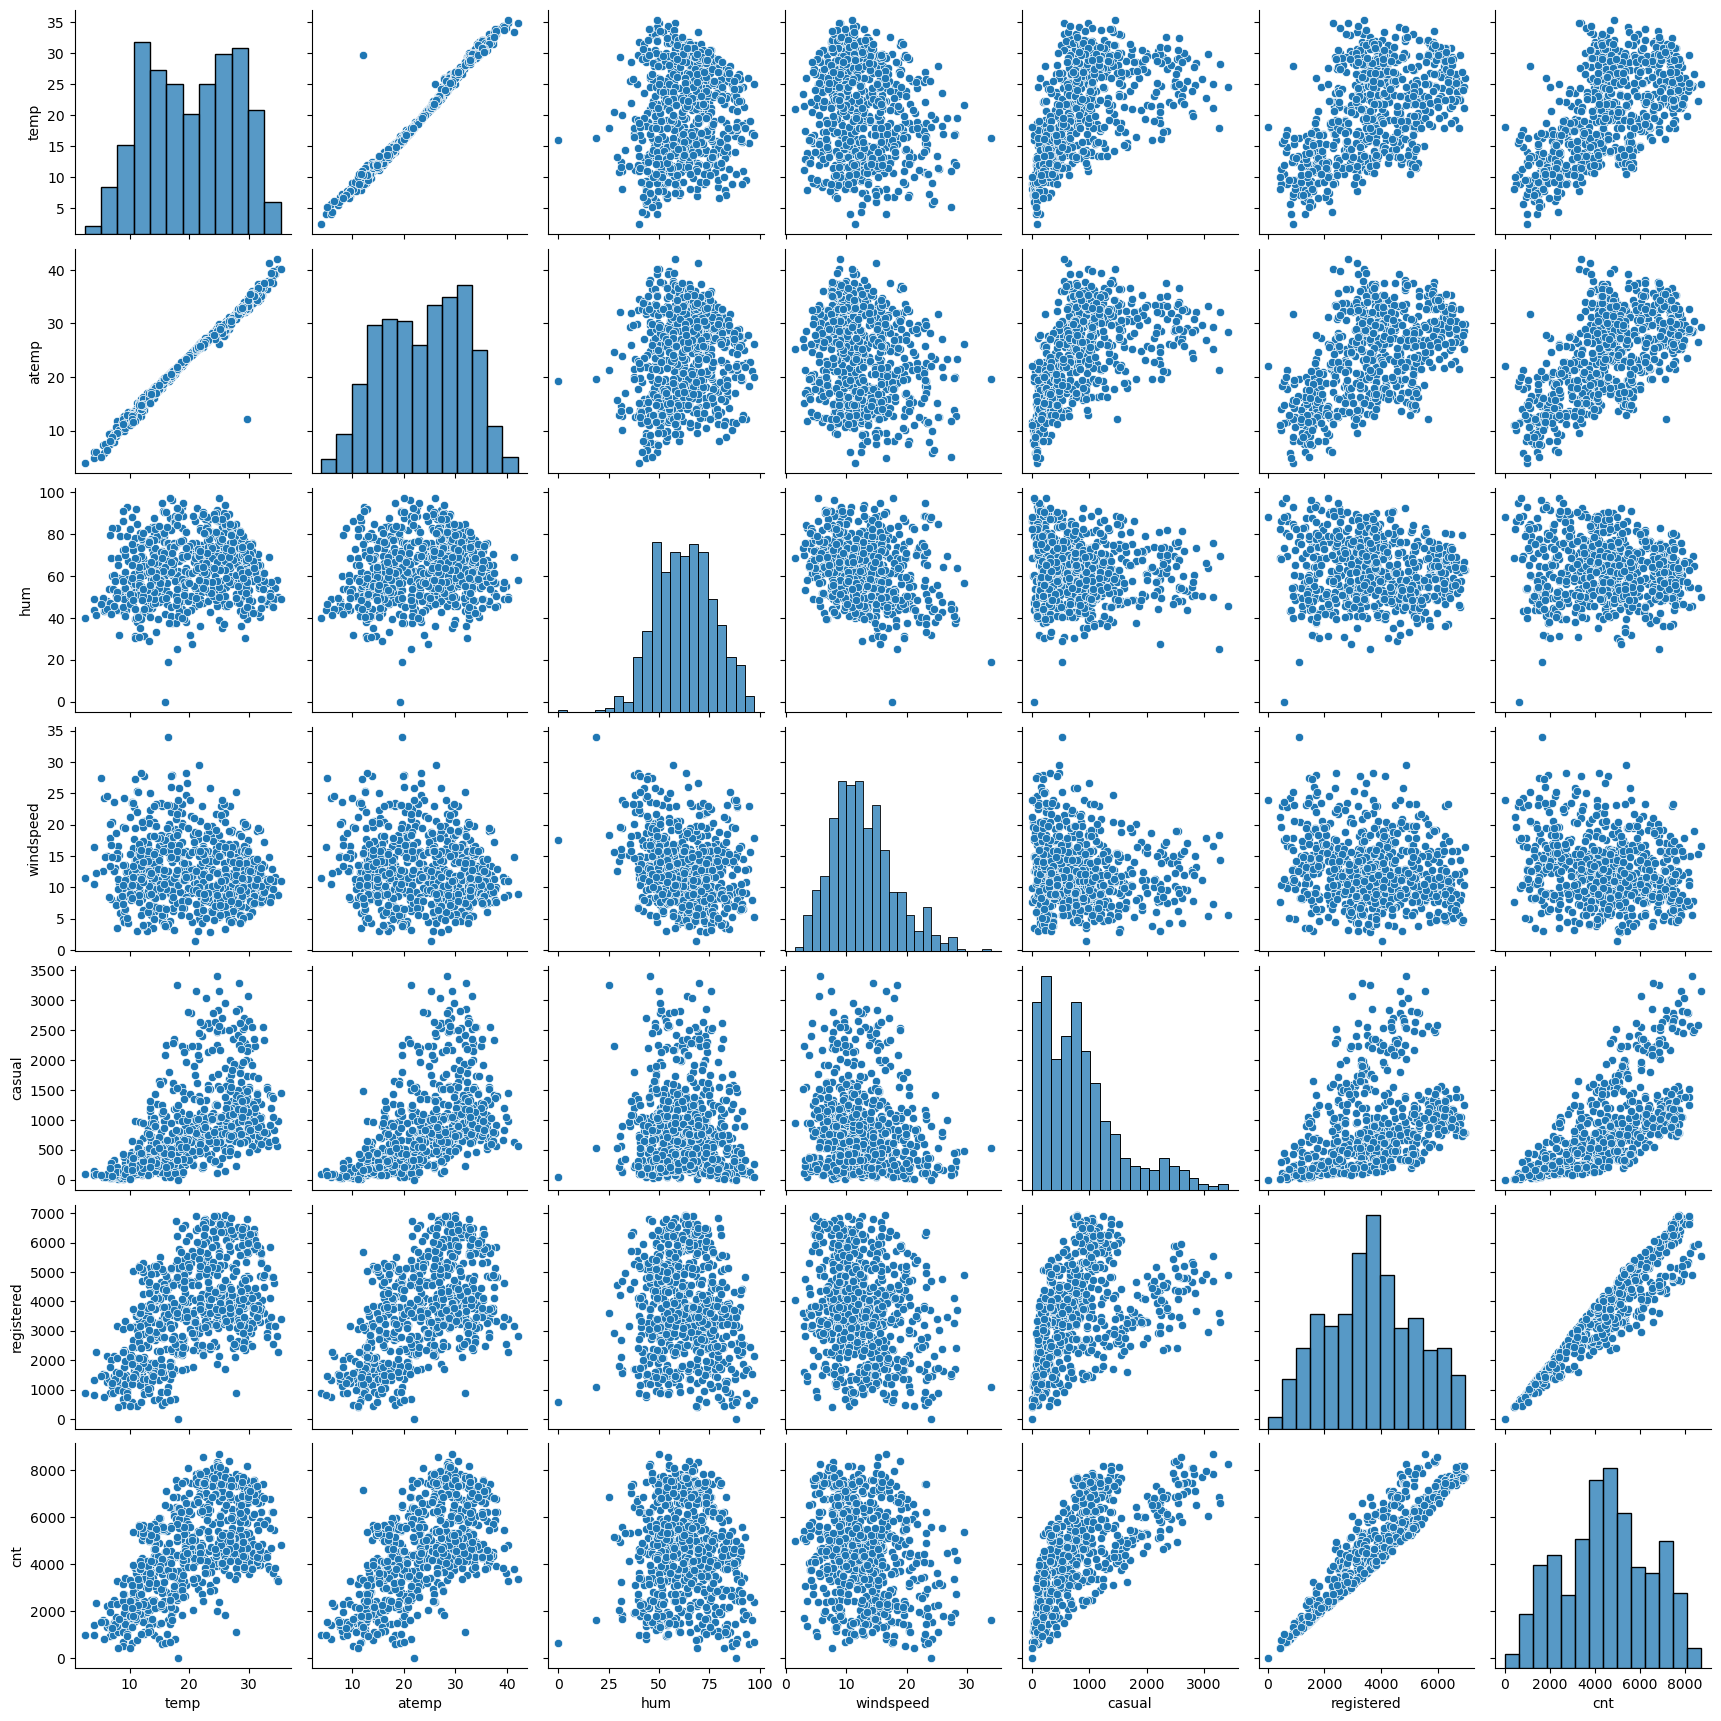

In [61]:
bike_pair = bike3[['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']]
sns.pairplot(bike_pair)
plt.show()

##### Temp and a temp have high correlation with casual, registered, cnt.
##### Here we are taking only 1 o/p variable as cnt. Casual and registered are considered in cnt.
##### We can say that temp & atemp have high correletion with cnt

## Final Variable after preprocessing

In [62]:
bike_final = bike3.copy()

## Dividing into train and test set

In [63]:
train_bike, test_bike = train_test_split(bike_final, train_size=0.7, random_state=100)
print(train_bike.shape)
print(test_bike.shape)

(510, 18)
(220, 18)


## Scaling train dataset 

In [64]:
num_col = ['temp', 'atemp', 'hum', 'windspeed', 'casual',
       'registered', 'cnt']

scaler = MinMaxScaler()
train_bike[num_col] = scaler.fit_transform(train_bike[num_col])
train_bike.head()

,instant,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,light_weather,mist_weather,spring,summer,winter
576,577,1,7,0,2,1,0.815169,0.766351,0.725633,0.264686,0.294422,0.899220,0.827658,0,0,0,0,0
426,427,1,3,0,6,0,0.442393,0.438975,0.640189,0.255342,0.290765,0.446145,0.465255,0,1,1,0,0
728,729,1,12,0,0,0,0.245101,0.200348,0.498067,0.663106,0.110332,0.203869,0.204096,0,0,1,0,0
482,483,1,4,0,6,0,0.395666,0.391735,0.504508,0.188475,0.340750,0.444701,0.482973,0,1,0,1,0
111,112,0,4,0,5,1,0.345824,0.318819,0.751824,0.380981,0.053337,0.214554,0.191095,0,1,0,1,0


In [65]:
train_bike.describe()

,instant,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,light_weather,mist_weather,spring,summer,winter
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,368.680392,0.507843,6.541176,0.025490,2.990196,0.676471,0.537440,0.513156,0.650480,0.320883,0.254689,0.523781,0.513499,0.029412,0.345098,0.243137,0.247059,0.247059
std,209.596164,0.500429,3.465416,0.157763,2.017093,0.468282,0.225858,0.212410,0.145846,0.169803,0.206015,0.227896,0.224421,0.169124,0.475867,0.429398,0.431725,0.431725
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,187.250000,0.000000,3.000000,0.000000,1.000000,0.000000,0.339853,0.332086,0.538643,0.199179,0.094179,0.353487,0.356420,0.000000,0.000000,0.000000,0.000000,0.000000
50%,373.000000,1.000000,7.000000,0.000000,3.000000,1.000000,0.542596,0.529718,0.653714,0.296763,0.212740,0.525123,0.518638,0.000000,0.000000,0.000000,0.000000,0.000000
75%,552.750000,1.000000,10.000000,0.000000,5.000000,1.000000,0.735215,0.688457,0.754830,0.414447,0.327415,0.696073,0.684710,0.000000,1.000000,0.000000,0.000000,0.000000
max,729.000000,1.000000,12.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Building Model1 - 'yr'

In [66]:
X_train = train_bike['yr']
y_train = train_bike['cnt']

X_train = sm.add_constant(X_train)
model1 = sm.OLS(y_train, X_train).fit()

print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     273.3
Date:                Tue, 07 Nov 2023   Prob (F-statistic):           1.95e-49
Time:                        01:36:13   Log-Likelihood:                 148.67
No. Observations:                 510   AIC:                            -293.3
Df Residuals:                     508   BIC:                            -284.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3788      0.011     33.131      0.0

With only year variable we are getting r-squared as 0.35.  
p-value is less (acceptale).  
Now lets add month also

## Model 2 - 'yr', 'mnth'

In [67]:
X_train = train_bike[['yr', 'mnth']]
y_train = train_bike['cnt']

X_train = sm.add_constant(X_train)
model2 = sm.OLS(y_train, X_train).fit()

print(model2.summary())

vif = pd.DataFrame()
X = X_train.drop('const', axis=1)
vif['features'] = X.columns
vif['vif'] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
vif['vif'] = vif['vif'].round(2)
vif = vif.sort_values(by='vif', ascending=False)

vif

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.434
Method:                 Least Squares   F-statistic:                     196.2
Date:                Tue, 07 Nov 2023   Prob (F-statistic):           7.76e-64
Time:                        01:36:13   Log-Likelihood:                 185.08
No. Observations:                 510   AIC:                            -364.2
Df Residuals:                     507   BIC:                            -351.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2530      0.018     14.206      0.0

,features,vif
0,yr,1.64
1,mnth,1.64


Adding month column has increased our r-squared value to 0.43.  
p value is less.(Acceptable)    
And VIF for all variables is less than 5 (acceptable).  


## Model 3 - yr,	mnth, holiday

In [68]:
X_train = train_bike[[ 'yr', 'mnth', 'holiday']]
y_train = train_bike['cnt']

X_train = sm.add_constant(X_train)
model3 = sm.OLS(y_train, X_train).fit()

print(model3.summary())

vif = pd.DataFrame()
X = X_train.drop('const', axis=1)
vif['features'] = X.columns
vif['vif'] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
vif['vif'] = vif['vif'].round(2)
vif = vif.sort_values(by='vif', ascending=False)

vif

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     135.6
Date:                Tue, 07 Nov 2023   Prob (F-statistic):           1.83e-64
Time:                        01:36:13   Log-Likelihood:                 189.33
No. Observations:                 510   AIC:                            -370.7
Df Residuals:                     506   BIC:                            -353.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2555      0.018     14.436      0.0

,features,vif
1,mnth,1.66
0,yr,1.64
2,holiday,1.03


By adding holiday, r-squared value is increased marginally and coefficient is -ve.  
Holiday has no impact on cnt. Dropping it  
Adding weekday in next model

## Model 4 - yr,	mnth, weekday

In [69]:
X_train = train_bike[[ 'yr', 'mnth', 'weekday']]
y_train = train_bike['cnt']

X_train = sm.add_constant(X_train)
model4 = sm.OLS(y_train, X_train).fit()

print(model4.summary())

vif = pd.DataFrame()
X = X_train.drop('const', axis=1)
vif['features'] = X.columns
vif['vif'] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
vif['vif'] = vif['vif'].round(2)
vif = vif.sort_values(by='vif', ascending=False)

vif

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     132.3
Date:                Tue, 07 Nov 2023   Prob (F-statistic):           2.85e-63
Time:                        01:36:13   Log-Likelihood:                 186.56
No. Observations:                 510   AIC:                            -365.1
Df Residuals:                     506   BIC:                            -348.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2334      0.021     11.056      0.0

,features,vif
1,mnth,2.49
2,weekday,2.27
0,yr,1.72


By adding weekday, r-squared value is increased marginally.  
Weekday has no impact on cnt. Dropping it  
Adding Workingday in next model

## Model 5 - yr,	mnth, workingday, temp

In [70]:
X_train = train_bike[[ 'yr', 'mnth', 'workingday', 'temp']]
y_train = train_bike['cnt']

X_train = sm.add_constant(X_train)
model5 = sm.OLS(y_train, X_train).fit()

print(model5.summary())

vif = pd.DataFrame()
X = X_train.drop('const', axis=1)
vif['features'] = X.columns
vif['vif'] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
vif['vif'] = vif['vif'].round(2)
vif = vif.sort_values(by='vif', ascending=False)

vif

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     321.2
Date:                Tue, 07 Nov 2023   Prob (F-statistic):          3.27e-137
Time:                        01:36:14   Log-Likelihood:                 361.54
No. Observations:                 510   AIC:                            -713.1
Df Residuals:                     505   BIC:                            -691.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0174      0.018      0.990      0.3

,features,vif
3,temp,5.16
1,mnth,3.93
2,workingday,2.61
0,yr,1.94


By adding temp, r-squared increased to 0.72.  
But p value for workingday is greater than 5%. (not good)  
VIF for temp is > 5 (not Good).  
We will drop temp and see the effect of adding atemp variable  

## Model 6 - yr,	mnth, workingday, atemp

In [71]:
X_train = train_bike[[ 'yr', 'mnth', 'workingday', 'atemp']]
y_train = train_bike['cnt']

X_train = sm.add_constant(X_train)
model6 = sm.OLS(y_train, X_train).fit()

print(model6.summary())

vif = pd.DataFrame()
X = X_train.drop('const', axis=1)
vif['features'] = X.columns
vif['vif'] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
vif['vif'] = vif['vif'].round(2)
vif = vif.sort_values(by='vif', ascending=False)

vif

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     326.9
Date:                Tue, 07 Nov 2023   Prob (F-statistic):          1.31e-138
Time:                        01:36:14   Log-Likelihood:                 364.79
No. Observations:                 510   AIC:                            -719.6
Df Residuals:                     505   BIC:                            -698.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0127      0.018      0.726      0.4

,features,vif
3,atemp,5.27
1,mnth,3.98
2,workingday,2.61
0,yr,1.94


By adding atemp, r-squared increased to 0.72.  
But p value for workingday is greater than 5%. (not good)  
VIF for temp is > 5 (not Good).  
We will drop atemp later and see the effect of adding humidity variable  

## Model 7 - yr,	mnth, workingday, atemp, hum

In [72]:
X_train = train_bike[[ 'yr', 'mnth', 'workingday', 'atemp', 'hum']]
y_train = train_bike['cnt']

X_train = sm.add_constant(X_train)
model7 = sm.OLS(y_train, X_train).fit()

print(model7.summary())

vif = pd.DataFrame()
X = X_train.drop('const', axis=1)
vif['features'] = X.columns
vif['vif'] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
vif['vif'] = vif['vif'].round(2)
vif = vif.sort_values(by='vif', ascending=False)

vif

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     292.9
Date:                Tue, 07 Nov 2023   Prob (F-statistic):          1.51e-146
Time:                        01:36:14   Log-Likelihood:                 386.33
No. Observations:                 510   AIC:                            -760.7
Df Residuals:                     504   BIC:                            -735.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1469      0.026      5.598      0.0

,features,vif
4,hum,9.31
3,atemp,7.10
1,mnth,5.01
2,workingday,2.95
0,yr,1.97


By adding humidity, r-squared increased from 0.72 to 0.74.    
VIF for hum is 9 (not Good).  
We will drop humidity and see the effect of adding windspeed variable  

## Model 8 - yr,	mnth, workingday, atemp, windspeed

In [73]:
X_train = train_bike[[ 'yr','mnth', 'workingday','atemp', 'windspeed']]
y_train = train_bike['cnt']

X_train = sm.add_constant(X_train)
model8 = sm.OLS(y_train, X_train).fit()

print(model8.summary())

vif = pd.DataFrame()
X = X_train.drop('const', axis=1)
vif['features'] = X.columns
vif['vif'] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
vif['vif'] = vif['vif'].round(2)
vif = vif.sort_values(by='vif', ascending=False)

vif

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     276.4
Date:                Tue, 07 Nov 2023   Prob (F-statistic):          7.27e-142
Time:                        01:36:14   Log-Likelihood:                 375.40
No. Observations:                 510   AIC:                            -738.8
Df Residuals:                     504   BIC:                            -713.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0778      0.022      3.503      0.0

,features,vif
3,atemp,5.58
1,mnth,4.11
4,windspeed,2.94
2,workingday,2.77
0,yr,2.00


By adding windspeed, r-squared value is reduced.(not good)  
p value for workingday increased (>5%, not good)   
dropping windspeed and adding  

## Model 9 - yr,	mnth, workingday, atemp, light_weather

In [74]:
X_train = train_bike[[ 'yr', 'mnth', 'workingday', 'atemp', 'light_weather']]
y_train = train_bike['cnt']

X_train = sm.add_constant(X_train)
model9 = sm.OLS(y_train, X_train).fit()

print(model9.summary())

vif = pd.DataFrame()
X = X_train.drop('const', axis=1)
vif['features'] = X.columns
vif['vif'] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
vif['vif'] = vif['vif'].round(2)
vif = vif.sort_values(by='vif', ascending=False)

vif

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     311.1
Date:                Tue, 07 Nov 2023   Prob (F-statistic):          1.74e-151
Time:                        01:36:14   Log-Likelihood:                 397.86
No. Observations:                 510   AIC:                            -783.7
Df Residuals:                     504   BIC:                            -758.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0195      0.016      1.185

,features,vif
3,atemp,5.28
1,mnth,4.05
2,workingday,2.62
0,yr,1.95
4,light_weather,1.04


By adding light_weather, r-squared increased. (good)  
all p values are < 5% (good)  
We are accepting light_weather at this moment and adding 'mist_weather

## Model 10 - yr,	mnth, workingday, atemp, light_weather, mist_weather

In [75]:
X_train = train_bike[['yr','mnth', 'workingday','atemp', 
       'light_weather', 'mist_weather']]
y_train = train_bike['cnt']

X_train = sm.add_constant(X_train)
model10 = sm.OLS(y_train, X_train).fit()

print(model10.summary())

vif = pd.DataFrame()
X = X_train.drop('const', axis=1)
vif['features'] = X.columns
vif['vif'] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
vif['vif'] = vif['vif'].round(2)
vif = vif.sort_values(by='vif', ascending=False)

vif

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     289.9
Date:                Tue, 07 Nov 2023   Prob (F-statistic):          1.09e-159
Time:                        01:36:14   Log-Likelihood:                 420.02
No. Observations:                 510   AIC:                            -826.0
Df Residuals:                     503   BIC:                            -796.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0481      0.016      2.944

,features,vif
3,atemp,5.30
1,mnth,4.13
2,workingday,2.70
0,yr,1.95
5,mist_weather,1.46
4,light_weather,1.06


By adding mist_weather, r-squared increased to 0.77. (good)  
all p values are < 5% (good)  
We are accepting mist_weather at this moment and adding spring

## Model 11 - yr,	mnth, workingday, atemp, light_weather, mist_weather, spring

In [76]:
X_train = train_bike[['yr','mnth', 'workingday','atemp', 
       'light_weather', 'mist_weather','spring']]
y_train = train_bike['cnt']

X_train = sm.add_constant(X_train)
model11 = sm.OLS(y_train, X_train).fit()

print(model11.summary())

vif = pd.DataFrame()
X = X_train.drop('const', axis=1)
vif['features'] = X.columns
vif['vif'] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
vif['vif'] = vif['vif'].round(2)
vif = vif.sort_values(by='vif', ascending=False)

vif

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     295.5
Date:                Tue, 07 Nov 2023   Prob (F-statistic):          1.67e-173
Time:                        01:36:14   Log-Likelihood:                 455.35
No. Observations:                 510   AIC:                            -894.7
Df Residuals:                     502   BIC:                            -860.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2078      0.024      8.667

,features,vif
3,atemp,5.31
1,mnth,4.21
2,workingday,2.92
0,yr,2.02
5,mist_weather,1.50
6,spring,1.28
4,light_weather,1.06


By adding spring, r-squared increased to 0.80. (good)  
all p values are < 5% (good)  
We are accepting spring at this moment and adding winter

## Model 12 - yr,	mnth, workingday, atemp, light_weather, mist_weather, spring, winter

In [77]:
X_train = train_bike[['yr','mnth', 'workingday','atemp', 
       'light_weather', 'mist_weather', 'spring', 'winter']]
y_train = train_bike['cnt']

X_train = sm.add_constant(X_train)
model12 = sm.OLS(y_train, X_train).fit()

print(model12.summary())

vif = pd.DataFrame()
X = X_train.drop('const', axis=1)
vif['features'] = X.columns
vif['vif'] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
vif['vif'] = vif['vif'].round(2)
vif = vif.sort_values(by='vif', ascending=False)

vif

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     262.6
Date:                Tue, 07 Nov 2023   Prob (F-statistic):          8.55e-174
Time:                        01:36:14   Log-Likelihood:                 458.98
No. Observations:                 510   AIC:                            -900.0
Df Residuals:                     501   BIC:                            -861.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1936      0.024      7.927

,features,vif
1,mnth,12.41
3,atemp,8.67
7,winter,3.85
2,workingday,2.93
0,yr,2.04
5,mist_weather,1.51
6,spring,1.31
4,light_weather,1.06


Now month p value is very high  
and month vif is also > 10 (not good)  
We are dropping month variable

# Final Model 
## 'yr', 'workingday', 'atemp', 'light_weather','mist_weather', 'spring',  'winter'

In [78]:
X_train = train_bike[['yr', 'workingday', 'atemp', 'light_weather','mist_weather', 'spring',  'winter']]
y_train = train_bike['cnt']

X_train = sm.add_constant(X_train)
model_final = sm.OLS(y_train, X_train).fit()

print(model_final.summary())

vif = pd.DataFrame()
X = X_train.drop('const', axis=1)
vif['features'] = X.columns
vif['vif'] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
vif['vif'] = vif['vif'].round(2)
vif = vif.sort_values(by='vif', ascending=False)

vif

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     300.7
Date:                Tue, 07 Nov 2023   Prob (F-statistic):          4.83e-175
Time:                        01:36:14   Log-Likelihood:                 458.96
No. Observations:                 510   AIC:                            -901.9
Df Residuals:                     502   BIC:                            -868.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1922      0.023      8.291

,features,vif
2,atemp,3.34
1,workingday,2.92
0,yr,2.04
4,mist_weather,1.50
5,spring,1.31
6,winter,1.31
3,light_weather,1.06


## R-squared on train data

In [79]:
from sklearn.metrics import r2_score
y_train_pred = model_final.predict(X_train)
r2_score(y_train, y_train_pred)

0.8074330554101574

# Linear Regression equation :
#### cnt = 0.1922 + (0.2343 * yr) + (0.0254 * workingday) + (0.4638 * atemp) + (-0.2879 * light_weather) + (-0.0733 * mist_weather) + (-0.1250 * spring) + (0.0455 * winter)

Now we have reached to our final model.  
R-squared value is 0.80 which is good  
All vif values are very low. (good)  
We are accepting this model and check for the residuals for train and test data

## Residual Analysis

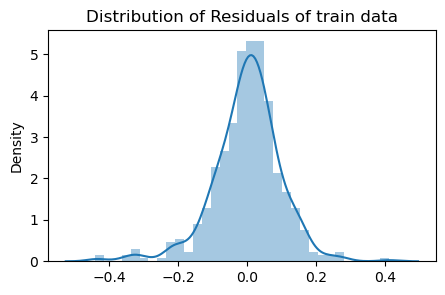

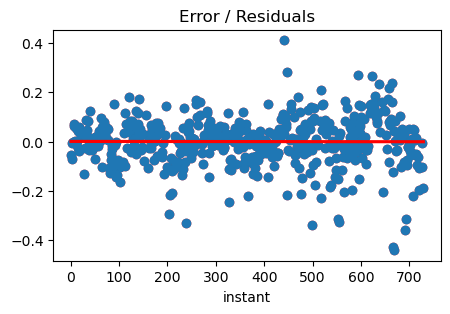

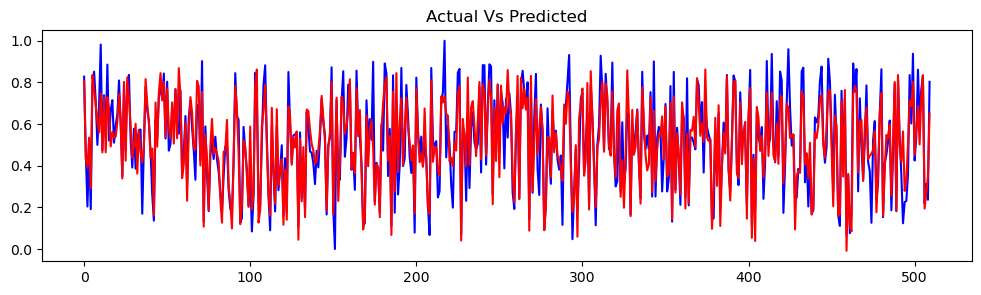

In [80]:
# Prediction on train data
y_train_pred = model_final.predict(X_train)
res = y_train - y_train_pred

plt.figure(figsize=(5,3))
sns.distplot(res)
plt.title('Distribution of Residuals of train data')
plt.plot()

plt.figure(figsize=(5,3))
sns.regplot(x=train_bike['instant'], y=res, color='r', ci=None)
plt.scatter(x=train_bike['instant'], y=res)
plt.title('Error / Residuals')
plt.show()

# Prediction on train data

plt.figure(figsize=(12,3))
x = range(train_bike.shape[0])
plt.plot(x, y_train, color='b')
plt.plot(x, y_train_pred, color='r')
plt.title('Actual Vs Predicted')
plt.show()

## Our model is fitting good on trainning data. Because:
- On training data, residuals or errors are random.  
- There is no pattren in error.  
- Residuals are normally distributed. 
- Variance is explained very well by the model 
- And trendline passing through residual has no significance


# Test data

### Scaling test data

In [81]:
num_col = ['temp', 'atemp', 'hum', 'windspeed', 'casual',
       'registered', 'cnt']


# scaler = MinMaxScaler()
test_bike[num_col] = scaler.transform(test_bike[num_col])
test_bike.head()

,instant,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,light_weather,mist_weather,spring,summer,winter
184,185,0,7,1,1,0,0.831783,0.769660,0.657364,0.084219,0.933557,0.427086,0.692706,0,1,0,0,0
535,536,1,6,0,3,1,0.901354,0.842587,0.610133,0.153728,0.265163,0.767976,0.712034,0,0,0,1,0
299,300,0,10,0,4,1,0.511964,0.496145,0.837699,0.334206,0.072539,0.346376,0.303382,0,1,0,0,1
221,222,0,8,0,3,1,0.881625,0.795343,0.437098,0.339570,0.268820,0.559630,0.547400,0,0,0,0,0
152,153,0,6,0,4,1,0.817246,0.741471,0.314298,0.537414,0.223712,0.608143,0.569029,0,0,0,1,0


In [82]:
test_bike.describe()

,instant,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,light_weather,mist_weather,spring,summer,winter
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000
mean,358.127273,0.481818,6.490909,0.036364,3.013636,0.700000,0.558718,0.532847,0.638221,0.313293,0.266436,0.529076,0.522154,0.027273,0.318182,0.254545,0.263636,0.236364
std,214.116582,0.500809,3.422316,0.187620,1.985057,0.459303,0.233187,0.217401,0.148694,0.159584,0.216751,0.219300,0.219163,0.163248,0.466833,0.436599,0.441609,0.425817
min,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.046591,0.025950,0.261915,-0.042808,0.002133,0.059486,0.048205,0.000000,0.000000,0.000000,0.000000,0.000000
25%,171.500000,0.000000,4.000000,0.000000,1.000000,0.000000,0.355429,0.344870,0.529197,0.198843,0.102484,0.359190,0.378595,0.000000,0.000000,0.000000,0.000000,0.000000
50%,350.500000,0.000000,6.000000,0.000000,3.000000,1.000000,0.558172,0.544652,0.625590,0.300126,0.225236,0.527577,0.524678,0.000000,0.000000,0.000000,0.000000,0.000000
75%,539.750000,1.000000,9.000000,0.000000,5.000000,1.000000,0.755981,0.713308,0.743798,0.402718,0.361780,0.667088,0.677750,0.000000,1.000000,1.000000,1.000000,0.000000
max,730.000000,1.000000,12.000000,1.000000,6.000000,1.000000,0.984424,0.980934,1.002146,0.807474,1.038708,0.985273,0.963300,1.000000,1.000000,1.000000,1.000000,1.000000


# Prediction on Test data

RSS =  2.0534823423243944


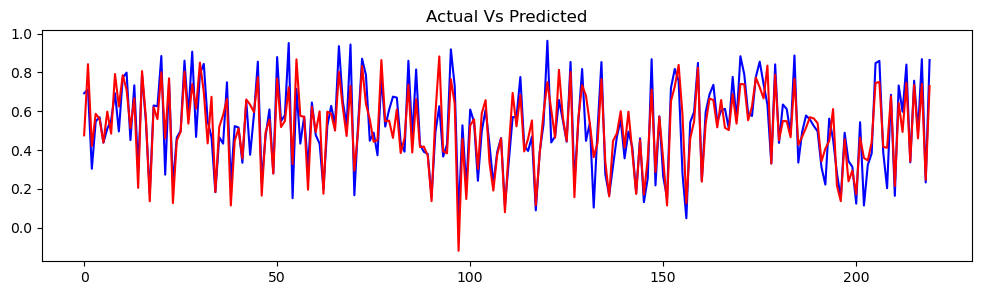

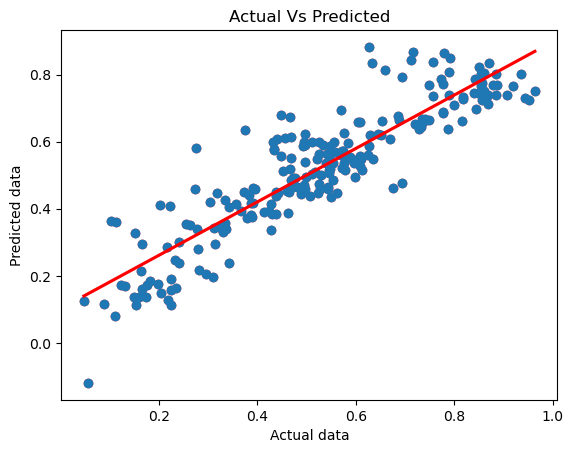

In [83]:
# Prediction on test data
X_test = test_bike[[ 'yr', 'workingday', 'atemp', 'light_weather',
 'mist_weather', 'spring',  'winter']]
y_test = test_bike['cnt']

X_test = sm.add_constant(X_test)
y_test_pred = model_final.predict(X_test)
res = y_test - y_test_pred
res = res ** 2
RSS = res.sum()
print("RSS = ", RSS)

plt.figure(figsize=(12,3))
x = range(220)
plt.plot(x, y_test, color='b')
plt.plot(x, y_test_pred, color='r')
plt.title('Actual Vs Predicted')
plt.show()

sns.regplot(x=y_test, y=y_test_pred, color='r', ci=None)
plt.scatter(y_test, y_test_pred)
plt.title('Actual Vs Predicted')
plt.xlabel("Actual data")
plt.ylabel("Predicted data")
plt.show()

## R-squared for test data

In [84]:
from sklearn.metrics import r2_score

r2_score(y_test, y_test_pred)

0.8047861278455138

# Residual Analysis on test data

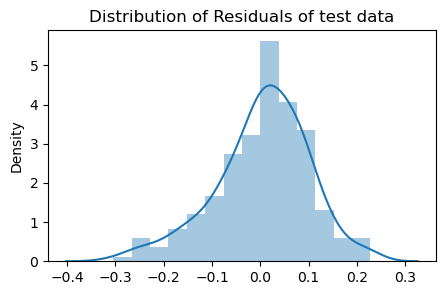

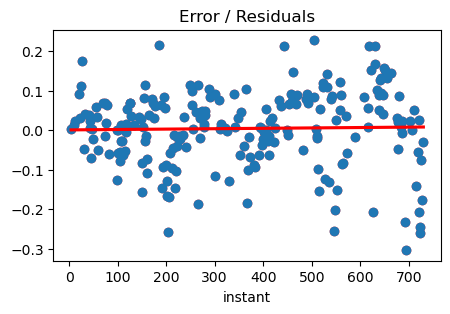

In [85]:
res = y_test - y_test_pred

plt.figure(figsize=(5,3))
sns.distplot(res)
plt.title('Distribution of Residuals of test data')
plt.plot()

plt.figure(figsize=(5,3))
sns.regplot(x=test_bike['instant'], y=res, color='r', ci=None)
plt.scatter(x=test_bike['instant'], y=res)
plt.title('Error / Residuals')
plt.show()

## Our model is fitting good on testing data too. Because:
### Prediction:
- R-squared is 0.80 which is high. (good)
- RSS value is 2 which is less.
- From graph, we can say that predicted test data is matching with actual test data.  
- There is a _+ve trend line between actual and predicted test values.   
### Residuals:
- On testing data, residuals or errors are random.  
- There is no pattren in error.  
- Residuals are normally distributed. 
- Variance is explained very well by the model "
- And trendline passing through residual has no significance
